# 3D U-Nets prediction

In [1]:
!pip install segmentation-models-3D

In [2]:
!pip install patchify

In [4]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2024-05-27 13:38:44.712770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 13:38:45.472392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1
3.3.3


In [6]:
import sys
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from patchify import unpatchify
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [8]:
sm.__version__

'1.0.6'

In [10]:
# Load NPY files
test_original_3D = np.load('/media/my_ftp/BasesDeDatos_Paranasal_CAT/CT_Craneal/DL_Models/Model_3D/3D_data_cv/cv9/3D_test_original9.npy')
test_mask_3D = np.load('/media/my_ftp/BasesDeDatos_Paranasal_CAT/CT_Craneal/DL_Models/Model_3D/3D_data_cv/cv9/3D_test_mask9.npy')

In [19]:
# Back to 512x512x64
original_patches_reshaped = np.reshape(test_original_3D[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64) )
mask_patches_reshaped = np.reshape(test_mask_3D[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64) )
reconstructed_original = unpatchify(original_patches_reshaped, (512,512,64))
reconstructed_mask = unpatchify(mask_patches_reshaped, (512,512,64))

In [18]:
# DICE
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    dice = (2.0 * intersection) / (union + 1e-8)
    return dice

In [179]:
# Normalization
scaler = MinMaxScaler()
test_original_ori = scaler.fit_transform(test_original_3D.reshape(-1, test_original_3D.shape[-1])).reshape(test_original_3D.shape)

Vanilla 3D U-Net

In [180]:
model_ori = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/withcv/vanilla_3D_cv9.h5', compile=False)

In [181]:
ori_prediction = model_ori.predict(test_original_ori[:,:,:,:,0])

In [182]:
binary_ori = (ori_prediction > 0.5).astype(int)

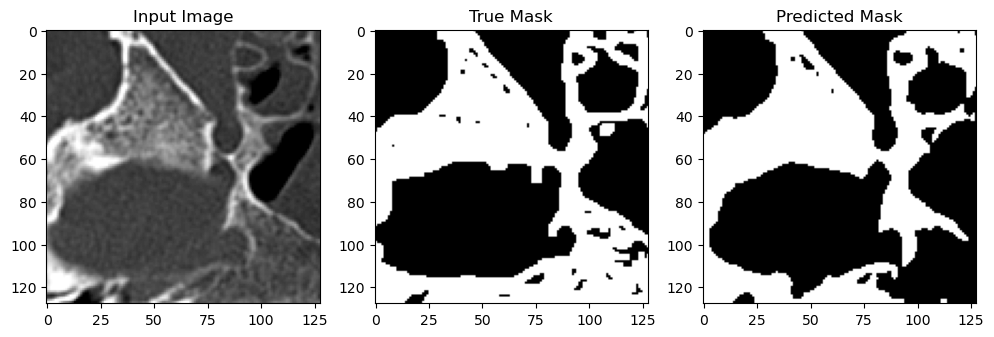

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(test_original_3D[5,:,:,43,0], cmap='gray')
axes[0].set_title('Input Image')

axes[1].imshow(test_mask_3D[5,:,:,43,0], cmap='gray')
axes[1].set_title('True Mask')

axes[2].imshow(binary_ori[5,:,:,43,0], cmap='gray')
axes[2].set_title('Predicted Mask')
    
plt.show()

In [183]:
ori_patches_reshaped = np.reshape(binary_ori[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64))
ori_reconstructed = unpatchify(ori_patches_reshaped, (512,512,64))

In [184]:
D_ori = dice_coefficient(reconstructed_mask, ori_reconstructed)
print("DICE of using the original structure of Unet 3D:", D_ori)

DICE of using the original structure of Unet 3D: 0.8970230925097908


In [56]:
for sample_idx in range(64):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(reconstructed_original[:,:,sample_idx], cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(reconstructed_mask[:,:,sample_idx], cmap='gray')
    axes[1].set_title('True Mask')

    axes[2].imshow(ori_reconstructed[:,:,sample_idx], cmap='gray')
    axes[2].set_title('Predicted Mask')

    #save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/Unet3D' 
    save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/ONLYVANILA'
    os.makedirs(save_dir, exist_ok=True)

    plt.savefig(os.path.join(save_dir, f'Test_Unet3D_slice_{sample_idx}.png'))
    plt.close()

3D U-Net with ResNet50 as backbone

In [21]:
preprocess_resn = sm.get_preprocessing('resnet50')
test_original_resn = preprocess_resn(test_original_3D)

In [12]:
model_resn = load_model('/media/my_ftp/BasesDeDatos_Paranasal_CAT/CT_Craneal/DL_Models/Model_3D/resnet50_3D_cv9.h5', compile=False)

2024-05-27 13:46:41.204641: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
resn_prediction = model_resn.predict(test_original_resn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [23]:
binary_resn = (resn_prediction > 0.5).astype(int)

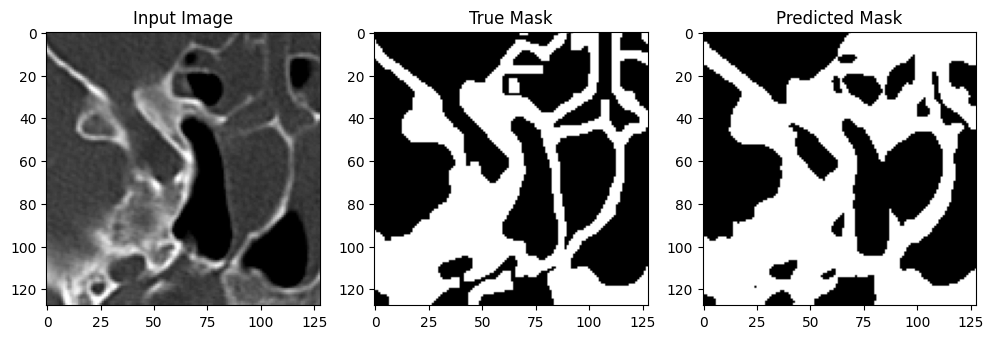

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(test_original_3D[5,:,:,43,0], cmap='gray')
axes[0].set_title('Input Image')

axes[1].imshow(test_mask_3D[5,:,:,43,0], cmap='gray')
axes[1].set_title('True Mask')

axes[2].imshow(binary_resn[5,:,:,43,0], cmap='gray')
axes[2].set_title('Predicted Mask')
    
plt.show()

In [24]:
resn_patches_reshaped = np.reshape(binary_resn[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64))
resn_reconstructed = unpatchify(resn_patches_reshaped, (512,512,64))

In [25]:
D_resn = dice_coefficient(reconstructed_mask, resn_reconstructed)
print("DICE of using the resnet50 as encoder:", D_resn)

DICE of using the resnet50 as encoder: 0.0


In [14]:
for sample_idx in range(64):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(reconstructed_original[:,:,sample_idx], cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(reconstructed_mask[:,:,sample_idx], cmap='gray')
    axes[1].set_title('True Mask')

    axes[2].imshow(resn_reconstructed[:,:,sample_idx], cmap='gray')
    axes[2].set_title('Predicted Mask')

    save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/resnet50'
    #save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/Au_resnet50' 
    os.makedirs(save_dir, exist_ok=True)

    plt.savefig(os.path.join(save_dir, f'Test_encoder_resnet50_slice_{sample_idx}.png'))
    plt.close()

3D U-Net with VGG16 as backbone

In [191]:
preprocess_vgg = sm.get_preprocessing('vgg16')
test_original_vgg = preprocess_vgg(test_original_3D)

In [192]:
model_vgg = load_model('/Users/yichunsun/Desktop/TFM/Data/3D/3D_model/withcv/vgg16_3D_cv9.h5', compile=False)

In [193]:
vgg_prediction = model_vgg.predict(test_original_vgg)

In [194]:
binary_vgg = (vgg_prediction > 0.5).astype(int)

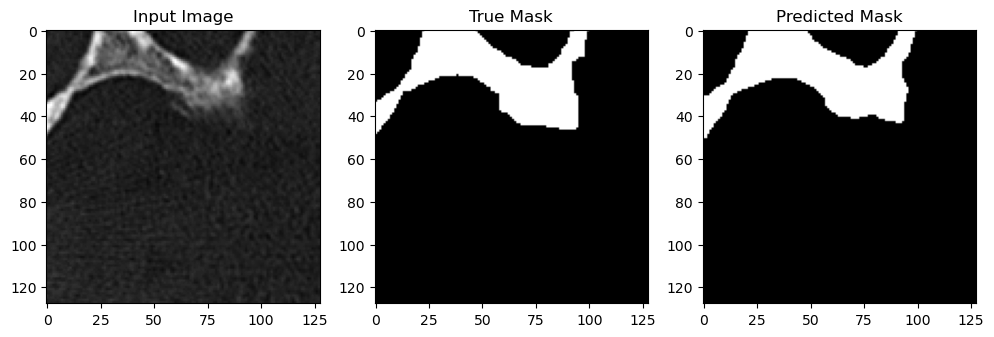

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(test_original_3D[5,:,:,59,0], cmap='gray')
axes[0].set_title('Input Image')

axes[1].imshow(test_mask_3D[5,:,:,59,0], cmap='gray')
axes[1].set_title('True Mask')

axes[2].imshow(binary_vgg[5,:,:,59,0], cmap='gray')
axes[2].set_title('Predicted Mask')
    
plt.show()

In [195]:
vgg_patches_reshaped = np.reshape(binary_vgg[:,:,:,:,0],
                                        (4, 4, 1, 128, 128, 64))
vgg_reconstructed = unpatchify(vgg_patches_reshaped, (512,512,64))

In [196]:
D_vgg = dice_coefficient(reconstructed_mask, vgg_reconstructed)
print("DICE of using the vgg16 as encoder:", D_vgg)

DICE of using the vgg16 as encoder: 0.8717827986534352


In [32]:
for sample_idx in range(64):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(reconstructed_original[:,:,sample_idx], cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(reconstructed_mask[:,:,sample_idx], cmap='gray')
    axes[1].set_title('True Mask')

    axes[2].imshow(vgg_reconstructed[:,:,sample_idx], cmap='gray')
    axes[2].set_title('Predicted Mask')

    #save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/vgg16' 
    save_dir = '/Users/yichunsun/Desktop/TFM/Data/3D/Results/PredictResult/Au_vgg16'
    os.makedirs(save_dir, exist_ok=True)

    plt.savefig(os.path.join(save_dir, f'Test_encoder_vgg16_slice_{sample_idx}.png'))
    plt.close()